In [10]:
from tespy.networks import Network
from tespy.components import MovingBoundaryHeatExchanger as HeatExchanger
from tespy.components import Source, Sink, Valve, CycleCloser, Compressor
from tespy.connections import Connection, Bus

In [11]:
nw = Network(T_unit="C", p_unit="bar", h_unit="kJ / kg", m_unit="kg / s", s_unit="kJ / kgK", iterinfo=False)

air_in = Source("air inlet")
air_out = Sink("air outlet")

water_in = Source("water inlet")
water_out = Sink("water outlet")

air_hx = HeatExchanger("AIR_HX")
comp1 = Compressor("COMP1")
valve1 = Valve("VAL1")
cc1 = CycleCloser("cc")

ihx = HeatExchanger("IHX")

steam_gen = HeatExchanger("STEAM_GEN")
comp2 = Compressor("COMP2")
valve2 = Valve("VAL2")
cc2 = CycleCloser("cc2")

c11 = Connection(air_in, "out1", air_hx, "in1", label="11")
c12 = Connection(air_hx, "out1", air_out, "in1", label="12")

c21 = Connection(air_hx, "out2", comp1, "in1", label="21")
c22 = Connection(comp1, "out1", ihx, "in1", label="22")
c22c = Connection(ihx, "out1", cc1, "in1", label="23")
c23 = Connection(cc1, "out1", valve1, "in1", label="23c")
c24 = Connection(valve1, "out1", air_hx, "in2", label="24")

c31 = Connection(ihx, "out2", comp2, "in1", label="31")
c32 = Connection(comp2, "out1", steam_gen, "in1", label="32")
c32c = Connection(steam_gen, "out1", cc2, "in1", label="33")
c33 = Connection(cc2, "out1", valve2, "in1", label="33c")
c34 = Connection(valve2, "out1", ihx, "in2", label="34")

c41 = Connection(water_in, "out1", steam_gen, "in2", label="41")
c42 = Connection(steam_gen, "out2", water_out, "in1", label="42")

nw.add_conns(c21, c22, c22c, c23, c24)
nw.add_conns(c11, c12)
nw.add_conns(c31, c32, c32c, c33, c34)
nw.add_conns(c41, c42)

# Simulation with starting values

c11.set_attr(fluid={"Ar": 0.0129, "CO2": 0.0005, "N2": 0.7552, "O2": 0.2314}, T=20, p=1.013)
c12.set_attr(T=15)

c21.set_attr(fluid={"R245FA": 1}, h=417)
c22.set_attr(p=6.4)
c23.set_attr(h=290)
c24.set_attr(p=0.823)

c31.set_attr(fluid={"R1233zdE": 1}, h=451)
c32.set_attr(p=17.5)
c33.set_attr(h=364)
c34.set_attr(p=4.1)

c41.set_attr(fluid={"water": 1}, T=120, x=0, m=1)
c42.set_attr(h=2706)

comp1.set_attr(eta_s=0.8)
comp2.set_attr(eta_s=0.8)

steam_gen.set_attr(pr1=1, pr2=1)
air_hx.set_attr(pr1=1, pr2=1)
ihx.set_attr(pr1=1, pr2=1)

nw.solve("design")

# Simulation with fixed values

c21.set_attr(h=None, Td_bp=5)
c22.set_attr(p=None)
c23.set_attr(h=None, Td_bp=-5)
c24.set_attr(p=None)

c31.set_attr(h=None, Td_bp=5)
c32.set_attr(p=None)
c33.set_attr(h=None, x=0)
c34.set_attr(p=None, T=60)

c42.set_attr(h=None, x=1)

air_hx.set_attr(ttd_l=5)
ihx.set_attr(ttd_l=5)
steam_gen.set_attr(ttd_l=5)

power_input = Bus("power input")
power_input.add_comps(
    {"comp": comp1, "base": "bus", "char": 0.985},
    {"comp": comp2, "base": "bus", "char": 0.985}
)

nw.add_busses(power_input)

nw.solve("design")
nw.print_results()

Q_out = c42.m.val * (c42.h.val - c41.h.val)
COP2 = c42.m.val * (c42.h.val - c41.h.val) / (comp2.P.val*1e-3)
COP1 = c31.m.val * (c31.h.val - c34.h.val) / (comp1.P.val*1e-3)
COP = c42.m.val * (c42.h.val - c41.h.val) / (power_input.P.val*1e-3)

print("Q = ", round(Q_out, 1), "kW")
print("COP = ", round(COP, 3))
print("COP1 = ", round(COP1, 3))
print("COP2 = ", round(COP2, 3))

# assert convergence of calculation
nw.assert_convergence()


##### RESULTS (MovingBoundaryHeatExchanger) #####
+-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+-----------+------------+-----------+-----------+-------------+------------------+----------------+----------------+---------------------+-------------------+------------------+-----------------------+---------------------+-----+----------+------------+
|           |         Q |       kA |   td_log |    ttd_u |    ttd_l |   ttd_min |      pr1 |      pr2 |      dp1 |       dp2 |    zeta1 |     zeta2 |   eff_cold |   eff_hot |   eff_max |   U_gas_gas |   U_gas_twophase |   U_gas_liquid |   U_liquid_gas |   U_liquid_twophase |   U_liquid_liquid |   U_twophase_gas |   U_twophase_twophase |   U_twophase_liquid |   A |       UA |   td_pinch |
|-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+-----------+------------+-----

In [12]:
from fluprodia import FluidPropertyDiagram
import numpy as np

In [13]:
R245fa = FluidPropertyDiagram("R245FA")
R245fa.set_unit_system(T="°C", p="bar", h="kJ/kg", s="kJ/kgK")
R245fa.set_isolines_subcritical(0, 180)
R245fa.set_isolines(s=np.array([1.25, 1.5, 1.75, 2.0]))
R245fa.calc_isolines()

In [14]:
R1233zdE = FluidPropertyDiagram("R1233zdE")
R1233zdE.set_unit_system(T="°C", p="bar", h="kJ/kg", s="kJ/kgK")
R1233zdE.set_isolines_subcritical(0, 180)
R1233zdE.set_isolines(s=np.array([1.25, 1.5, 1.75, 2.0]))
R1233zdE.calc_isolines()

In [15]:
from matplotlib import pyplot as plt

In [16]:
processes = {}
points = {}
for fluid in ["R1233zdE", "R245FA"]:
    if fluid == "R1233zdE":
        diagram = R1233zdE
    elif fluid == "R245FA":
        diagram = R245fa

    processes[fluid] = {}
    points[fluid] = {}
    conns = [c for c in nw.conns["object"] if fluid in c.fluid.val]
    comps = [
        cp for cp in nw.comps["object"]
        if len(set(conns) & set(cp.inl + cp.outl)) > 0
    ]

    for cp in comps:
        data = cp.get_plotting_data()
        if data is None:
            continue

        if isinstance(cp, HeatExchanger):
            if cp.inl[0] in conns and cp.inl[1] in conns:
                processes[fluid][f"{cp.label}_hot"] = diagram.calc_individual_isoline(**data[1])
                processes[fluid][f"{cp.label}_cold"] = diagram.calc_individual_isoline(**data[2])
                points[fluid][f"{cp.label}_hot"] = cp.outl[0].label
                points[fluid][f"{cp.label}_cold"] = cp.outl[1].label
            elif cp.inl[0] in conns:
                processes[fluid][cp.label] = diagram.calc_individual_isoline(**data[1])
                points[fluid][cp.label] = cp.outl[0].label
            else:
                processes[fluid][cp.label] = diagram.calc_individual_isoline(**data[2])
                points[fluid][cp.label] = cp.outl[1].label
        else:
            processes[fluid][cp.label] = diagram.calc_individual_isoline(**data[1])
            points[fluid][cp.label] = cp.outl[0].label


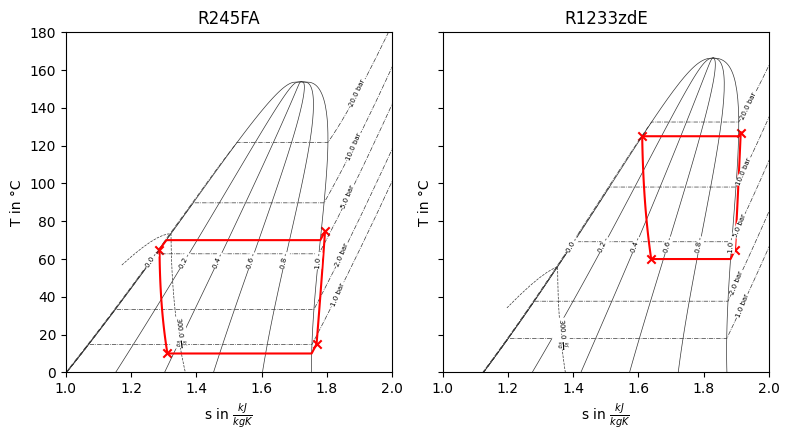

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4.5))

R1233zdE.draw_isolines(
    fig, ax[1], "Ts", 1, 2, 0, 180,
    isoline_data={
        "p": {"values": np.array([1, 2, 5, 10, 20])},
        "Q": {"values": np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])},
        "v": {"values": np.array([])},
        "h": {"values": np.array([200, 300, 400, 500])}
    }
)

for label, process in processes["R1233zdE"].items():
    ax[1].plot(process["s"], process["T"], color="red")
    ax[1].scatter(process["s"][-1], process["T"][-1], color="red", marker="x")


R245fa.draw_isolines(
    fig, ax[0], "Ts", 1, 2, 0, 180,
    isoline_data={
        "p": {"values": np.array([1, 2, 5, 10, 20])},
        "Q": {"values": np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])},
        "v": {"values": np.array([])},
        "h": {"values": np.array([200, 300, 400, 500])}
    }
)

for label, process in processes["R245FA"].items():
    ax[0].plot(process["s"], process["T"], color="red")
    ax[0].scatter(process["s"][-1], process["T"][-1], color="red", marker="x")

ax[0].set_title("R245FA")
ax[1].set_title("R1233zdE")

plt.tight_layout()
fig.savefig("Ts.svg")

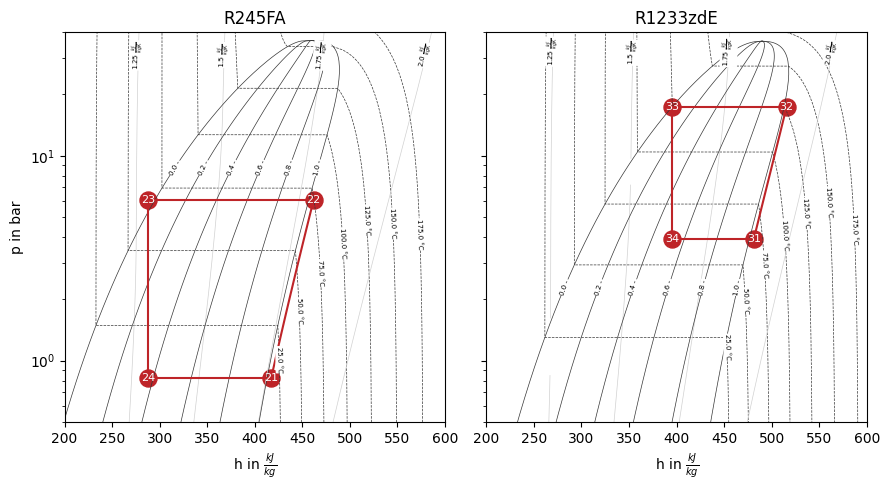

In [26]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 5))

R245fa.draw_isolines(
    fig, ax[0], "logph", 200, 600, 5e-1, 4e1,
    isoline_data={
        "Q": {"values": np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), "label_position": 0.32},
        "v": {"values": np.array([])},
        "T": {"values": np.arange(25.0, 176.0, 25.0), "label_position": 0.4},
        "s": {"values": np.array([1.25, 1.5, 1.75, 2.0]), "label_position": 0.7}
    }
)

# TU Berlin red
for label, process in processes["R245FA"].items():
    ax[0].plot(process["h"], process["p"], color="#be2428")
    ax[0].scatter(process["h"][-1], process["p"][-1], color="#be2428", s=150)
    ax[0].annotate(
        f'{points["R245FA"][label]}',
        (process["h"][-1], process["p"][-1]),
        ha='center', va='center', color='w', fontsize=8
        )

R1233zdE.draw_isolines(
    fig, ax[1], "logph", 200, 600, 5e-1, 4e1,
    isoline_data={
        "Q": {"values": np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), "label_position": 0.15},
        "v": {"values": np.array([])},
        "T": {"values": np.arange(25.0, 176.0, 25.0), "label_position": 0.4},
        "s": {"values": np.array([1.25, 1.5, 1.75, 2.0]), "label_position": 0.7}
    }
)

for label, process in processes["R1233zdE"].items():
    ax[1].plot(process["h"], process["p"], color="#be2428")
    ax[1].scatter(process["h"][-1], process["p"][-1], color="#be2428", s=150)
    ax[1].annotate(
        f'{points["R1233zdE"][label]}',
        (process["h"][-1], process["p"][-1]),
        ha='center', va='center', color='w', fontsize=8
        )

ax[0].set_title("R245FA")
ax[1].set_title("R1233zdE")

ax[1].set_ylabel(None)

plt.tight_layout()
fig.savefig("logph.svg")